In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [2]:
import sys, xgboost as xgb
print("Python:", sys.executable)
print("xgboost:", xgb.__version__)


Python: C:\Users\Admin\anaconda3\envs\ml-dl-nlp\python.exe
xgboost: 1.7.3


# 머신러닝 이진분류

In [3]:
import xgboost as xgb
print(xgb.__version__)


1.7.3


# 이진분류 1

In [4]:
import pandas as pd

CSV_PATH = r"인사평가_피쳐변환.csv"

# CP949 또는 EUC-KR 시도
df = pd.read_csv(CSV_PATH, encoding='cp949')
# df = pd.read_csv(CSV_PATH, encoding='euc-kr')

print(df.head())

        월급/경력  시급      월급/프로젝트    월급       월급/워라밸    일당      초과근무율     경력/나이  \
0  705.058824  94  1712.285714  5993  3995.333333  1102  13.689441  0.192771   
1  488.571429  61  2052.000000  5130  1465.714286   279   3.465839  0.202020   
2  278.666667  92   836.000000  2090   597.142857  1373  17.055901  0.186667   
3  342.235294  56   831.142857  2909   831.142857  1392  17.291925  0.238806   
4  533.538462  40   990.857143  3468   990.857143   591   7.341615  0.218182   

   나이  거리   프로젝트/경력   현근속/총근속     근속/경력  프로젝트/교육출장  현회사근속년수 업무평가  
0  41   1  0.352941  2.400000  0.235294   6.000000        6   보통  
1  49   8  0.190476  4.000000  0.190476   0.571429       10   좋다  
2  37   2  0.266667  0.000000  0.133333   0.571429        0   보통  
3  33   3  0.352941  5.333333  0.117647   0.857143        8   보통  
4  27   2  0.461538  1.333333  0.153846   0.857143        2   보통  


📊 피처: 15 | 숫자형: 15 | 범주형: 0
⚖️ scale_pos_weight(자동): 5.51

=== Validation (임계값 탐색) ===
best_thr=0.750 | best_accuracy=0.8409

=== Test (최적 임계값 적용) ===
- accuracy          : 0.8416
- precision_weighted: 0.7693
- recall_weighted   : 0.8416
- f1_weighted       : 0.7813

[Classification Report - Test]
              precision    recall  f1-score   support

       보통(0)     0.8486    0.9893    0.9136       187
       좋다(1)     0.3333    0.0294    0.0541        34

    accuracy                         0.8416       221
   macro avg     0.5910    0.5094    0.4838       221
weighted avg     0.7693    0.8416    0.7813       221


[Confusion Matrix - Test]
[[185   2]
 [ 33   1]]

[Top 20 Feature Importances]
  feature  importance
    근속/경력    5.067359
       월급    4.649663
  월급/프로젝트    4.400140
       거리    4.341806
  프로젝트/경력    4.325940
       일당    4.314610
       나이    4.164396
    월급/경력    4.156206
   월급/워라밸    4.145265
       시급    4.075249
    경력/나이    3.995375
  현회사근속년수    3.983150
    초과근무

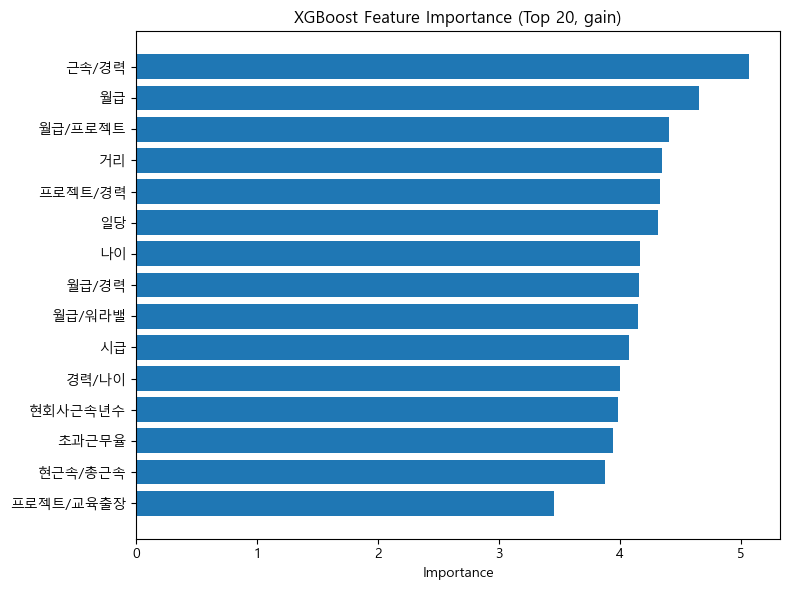

In [7]:
# =========================
# 인사평가 이진분류 - 최종 코드 (XGBoost 3.x)
# 정확도(accuracy) 중심, 임계값 최적화 + 피처 임포턴스( gain )
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.rc("font",family = "Malgun Gothic")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

import xgboost as xgb

# -------------------------
# 0) 데이터 로드 & 타깃 매핑
# -------------------------

# 인코딩 자동 시도(utf-8 → cp949)
try:
    df = pd.read_csv(CSV_PATH)
except UnicodeDecodeError:
    df = pd.read_csv(CSV_PATH, encoding="cp949")

TARGET_COL = "업무평가"
if TARGET_COL not in df.columns:
    raise ValueError(f"타깃 컬럼 '{TARGET_COL}' 이(가) 데이터에 없습니다. 실제 컬럼명을 확인해주세요.")

# 이진 타깃 매핑 (보통=0, 좋다=1) — 이미 숫자면 그대로 사용
if df[TARGET_COL].dtype == "O":
    bin_map = {"보통": 0, "좋다": 1}
    df[TARGET_COL] = df[TARGET_COL].map(bin_map).astype(int)

# -------------------------
# 1) 피처/타깃 분리
# -------------------------
y = df[TARGET_COL].values
X = df.drop(columns=[TARGET_COL])

# 숫자/범주형 자동 식별
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number, "float64", "int64", "int32", "float32"]).columns.tolist()

print(f"📊 피처: {X.shape[1]} | 숫자형: {len(num_cols)} | 범주형: {len(cat_cols)}")

# -------------------------
# 2) 데이터 분할 (train/val/test)
# -------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# -------------------------
# 3) 전처리 파이프라인
# -------------------------
num_tf = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# sklearn 버전 호환: sparse_output 지원 없으면 sparse 사용
try:
    cat_tf = Pipeline(steps=[
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
except TypeError:
    cat_tf = Pipeline(steps=[
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols)
    ],
    remainder="drop"
)

# -------------------------
# 4) 클래스 불균형 보정 (scale_pos_weight)
# -------------------------
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = max(1.0, neg / max(1, pos))
print(f"⚖️ scale_pos_weight(자동): {scale_pos_weight:.2f}")

# -------------------------
# 5) 전처리 적합 & 변환
# -------------------------
prep = preprocess.fit(X_train, y_train)
X_train_t = prep.transform(X_train)
X_val_t   = prep.transform(X_val)
X_test_t  = prep.transform(X_test)

# 변환 후 피처 이름 생성
num_feature_names = num_cols
if len(cat_cols) > 0:
    ohe = prep.named_transformers_["cat"].named_steps["ohe"]
    # get_feature_names_out 지원/미지원 호환
    try:
        cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
    except AttributeError:
        # 구버전 스케치: 카테고리 조합명 대신 단순 열 번호 부여
        cat_feature_names = []
        start = len(num_feature_names)
        for i in range(ohe.transform(pd.DataFrame({c: X_train[c] for c in cat_cols})).shape[1]):
            cat_feature_names.append(f"cat_{i}")
else:
    cat_feature_names = []
all_feature_names = num_feature_names + cat_feature_names

# -------------------------
# 6) XGBoost 학습 (조기종료)
# -------------------------
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,                 # reg_lambda
    "scale_pos_weight": scale_pos_weight,
    "tree_method": "hist",
    "seed": 42,
}

dtrain = xgb.DMatrix(X_train_t, label=y_train, feature_names=all_feature_names)
dval   = xgb.DMatrix(X_val_t,   label=y_val,   feature_names=all_feature_names)
dtest  = xgb.DMatrix(X_test_t,  label=y_test,  feature_names=all_feature_names)

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dval, "val")],
    early_stopping_rounds=50,
    verbose_eval=False
)

best_iter = getattr(bst, "best_iteration", None)
if best_iter is None:
    # 일부 버전은 best_ntree_limit만 제공
    best_iter = bst.best_ntree_limit - 1

# -------------------------
# 7) 임계값 최적화(정확도 기준) + 테스트 평가
# -------------------------
val_proba = bst.predict(dval, iteration_range=(0, best_iter + 1))
grid = np.linspace(0.2, 0.8, 61)
best_thr, best_acc = 0.5, -1.0
for t in grid:
    pred = (val_proba >= t).astype(int)
    acc = accuracy_score(y_val, pred)
    if acc > best_acc:
        best_thr, best_acc = t, acc
print(f"\n=== Validation (임계값 탐색) ===")
print(f"best_thr={best_thr:.3f} | best_accuracy={best_acc:.4f}")

test_proba = bst.predict(dtest, iteration_range=(0, best_iter + 1))
test_pred  = (test_proba >= best_thr).astype(int)

acc  = accuracy_score(y_test, test_pred)
prec = precision_score(y_test, test_pred, average="weighted", zero_division=0)
rec  = recall_score(y_test, test_pred, average="weighted", zero_division=0)
f1   = f1_score(y_test, test_pred, average="weighted", zero_division=0)

print("\n=== Test (최적 임계값 적용) ===")
print(f"- accuracy          : {acc:.4f}")
print(f"- precision_weighted: {prec:.4f}")
print(f"- recall_weighted   : {rec:.4f}")
print(f"- f1_weighted       : {f1:.4f}")

print("\n[Classification Report - Test]")
print(classification_report(y_test, test_pred, digits=4, target_names=["보통(0)", "좋다(1)"]))

cm = confusion_matrix(y_test, test_pred)
print("\n[Confusion Matrix - Test]")
print(cm)

# -------------------------
# 8) 피처 임포턴스 (gain)
# -------------------------
imp_dict = bst.get_score(importance_type="gain")  # {feature_name: score}
fi_df = (pd.DataFrame(list(imp_dict.items()), columns=["feature", "importance"])
         .sort_values("importance", ascending=False))

print("\n[Top 20 Feature Importances]")
print(fi_df.head(20).to_string(index=False))

# (선택) 시각화
top_k = min(20, len(fi_df))
if top_k > 0:
    fi_top = fi_df.head(top_k).iloc[::-1]
    plt.figure(figsize=(8, max(4, int(top_k*0.45))))
    plt.barh(fi_top["feature"], fi_top["importance"])
    plt.title("XGBoost Feature Importance (Top 20, gain)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# -------------------------
# 9) 단건 예측 유틸 (입력 딕셔너리 → 전처리 → DMatrix → 예측)
# -------------------------
def predict_one(sample_dict: dict, threshold: float | None = None):
    """
    sample_dict: {컬럼명: 값} (원본 데이터 컬럼명 기준, 범주형은 원래 라벨로 입력)
    threshold: None이면 best_thr 사용
    반환: {"proba_1": float, "threshold": float, "pred": int(0/1)}
    """
    # 1) 순서 정렬 및 누락 컬럼 채움
    x_one = pd.DataFrame([sample_dict])
    # 누락된 컬럼은 NaN → 전처리 파이프라인이 처리
    for col in X.columns:
        if col not in x_one.columns:
            x_one[col] = np.nan
    x_one = x_one[X.columns]  # 열 순서 맞춤

    # 2) 동일 전처리 적용
    x_one_t = prep.transform(x_one)

    # 3) DMatrix 변환 (같은 feature_names)
    done = xgb.DMatrix(x_one_t, feature_names=all_feature_names)

    # 4) 예측
    proba = float(bst.predict(done, iteration_range=(0, best_iter + 1))[0])
    thr = float(best_thr if threshold is None else threshold)
    pred = int(proba >= thr)
    return {"proba_1": proba, "threshold": thr, "pred": pred}

In [8]:
# 사용 예시
sample = {
    "나이": 35,
    "부서": "영업",         # 실제 데이터의 카테고리 값과 일치해야 함
    "근무기준시간": 80,
    "참여프로젝트": 7,
    "경력": 8,
    "전년도교육출장횟수": 3,
    "월급": 3500,
    "워라밸": 3,
    "현회사근속년수": 4,
    "근속연차": 5,
    "야근": "Yes",
    # ... 나머지 컬럼은 생략 가능(자동 NaN 채움 → 파이프라인 처리)
}
print(predict_one(sample))

{'proba_1': 0.1661013811826706, 'threshold': 0.7500000000000002, 'pred': 0}


# 이진분류 2

📊 피처: 15 | 숫자형: 15 | 범주형: 0
⚖️ scale_pos_weight(자동): 5.51

=== Validation (임계값 탐색) ===
best_thr=0.770 | best_accuracy=0.8455

=== Test (최적 임계값 적용) ===
- accuracy          : 0.8462
- precision_weighted: 0.7956
- recall_weighted   : 0.8462
- f1_weighted       : 0.7838

[Classification Report - Test]
              precision    recall  f1-score   support

       보통(0)     0.8493    0.9947    0.9163       187
       좋다(1)     0.5000    0.0294    0.0556        34

    accuracy                         0.8462       221
   macro avg     0.6747    0.5120    0.4859       221
weighted avg     0.7956    0.8462    0.7838       221


[Confusion Matrix - Test]
[[186   1]
 [ 33   1]]

[Top 20 Feature Importances]
  feature  importance
    근속/경력    4.584786
  현근속/총근속    4.376964
       월급    4.094516
       나이    4.047822
    경력/나이    3.967595
       일당    3.934552
  현회사근속년수    3.889309
  월급/프로젝트    3.830769
  프로젝트/경력    3.826720
   월급/워라밸    3.803447
       시급    3.751408
    월급/경력    3.649733
프로젝트/교육출

C:\Users\Admin\AppData\Local\Temp\ipykernel_13512\1776003748.py:226: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_13512\1776003748.py:226: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_13512\1776003748.py:226: UserWarning: Glyph 44540 (\N{HANGUL SYLLABLE GEUN}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_13512\1776003748.py:226: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_13512\1776003748.py:226: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_13512\1776003748.py:226: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from current font.
  plt.tight_la

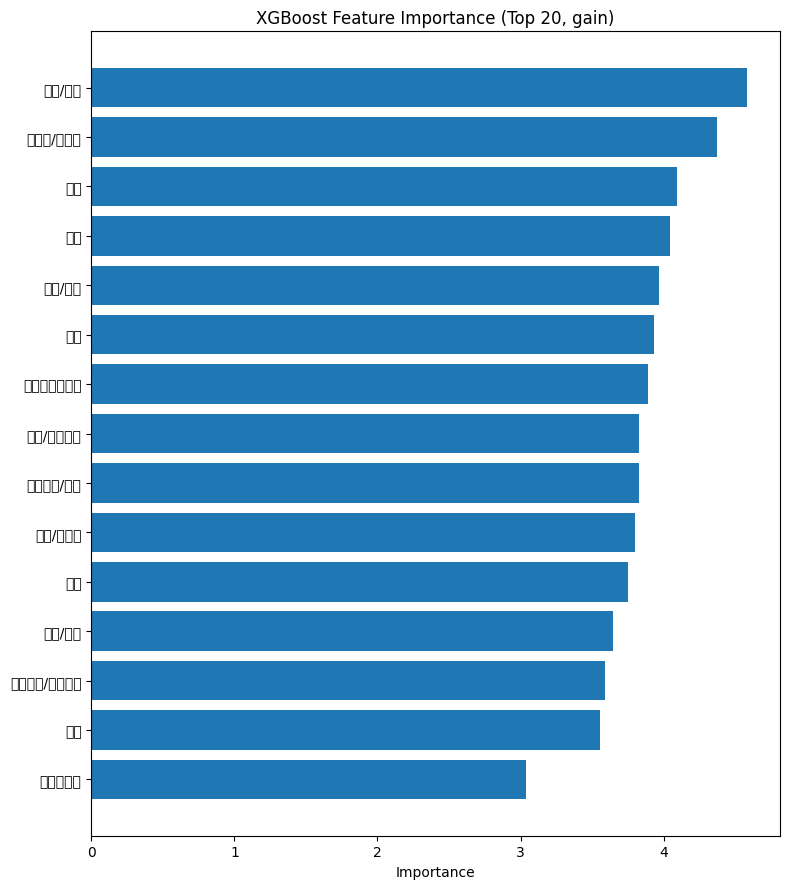

In [5]:
# # =========================
# # 인사평가 이진분류 - 최종 코드 (xgboost 3.0.3)
# # 정확도(accuracy) 중심, 임계값 최적화 + 피처 임포턴스
# # =========================
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score, f1_score,
#     classification_report, confusion_matrix
# )

# from xgboost import XGBClassifier
# from xgboost.callback import EarlyStopping

# # -------------------------
# # 0) 데이터 로드 & 타깃 매핑
# # -------------------------
# # ⚠️ 경로 수정하세요. (업로드하신 변환본을 기본값으로 설정)
# CSV_PATH = r"C:\Users\Admin\OneDrive\바탕 화면\2차 플젝\WA_Fn-UseC_-HR-Employee-Attrition_피쳐변환.csv"  # 예: r"C:\path\to\file.csv"

# df = pd.read_csv(CSV_PATH)

# # 타깃 컬럼명 설정 (예: '업무평가' 또는 사용자 환경의 타깃 컬럼명)
# TARGET_COL = "업무평가"
# if TARGET_COL not in df.columns:
#     raise ValueError(f"타깃 컬럼 '{TARGET_COL}' 이(가) 데이터에 없습니다. 실제 타깃 컬럼명을 확인해주세요.")

# # 이진 타깃 매핑 (보통=0, 좋다=1) — 이미 숫자면 건너뜀
# if df[TARGET_COL].dtype == 'O':
#     bin_map = {'보통': 0, '좋다': 1}
#     df[TARGET_COL] = df[TARGET_COL].map(bin_map).astype(int)

# # -------------------------
# # 1) 피처/타깃 분리
# # -------------------------
# y = df[TARGET_COL].values
# X = df.drop(columns=[TARGET_COL])

# # 숫자/범주형 자동 식별
# cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
# num_cols = X.select_dtypes(include=[np.number, "float64", "int64", "int32", "float32"]).columns.tolist()

# print(f"📊 피처: {X.shape[1]} | 숫자형: {len(num_cols)} | 범주형: {len(cat_cols)}")

# # -------------------------
# # 2) 데이터 분할 (train/val/test)
# # -------------------------
# # stratify로 클래스 비율 유지
# X_train, X_temp, y_train, y_temp = train_test_split(
#     X, y, test_size=0.3, random_state=42, stratify=y
# )
# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
# )

# # -------------------------
# # 3) 전처리 파이프라인
# # -------------------------
# num_tf = Pipeline(steps=[
#     ("scaler", StandardScaler())
# ])
# cat_tf = Pipeline(steps=[
#     ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
# ])

# preprocess = ColumnTransformer(
#     transformers=[
#         ("num", num_tf, num_cols),
#         ("cat", cat_tf, cat_cols)
#     ],
#     remainder="drop"
# )

# # -------------------------
# # 4) 클래스 불균형 보정 (scale_pos_weight)
# # -------------------------
# # pos_weight = (음성 수 / 양성 수)
# pos = (y_train == 1).sum()
# neg = (y_train == 0).sum()
# scale_pos_weight = max(1.0, neg / max(1, pos))
# print(f"⚖️ scale_pos_weight(자동): {scale_pos_weight:.2f}")

# # -------------------------
# # 5) XGBoost 분류기 정의 (3.0.3 → 콜백으로 조기종료)
# # -------------------------
# clf = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="logloss",         # 생성자에서만 설정
#     n_estimators=5000,             # 충분히 크게 → 조기종료로 최적 트리로 수렴
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=1.0,
#     scale_pos_weight=scale_pos_weight,
#     tree_method="hist",
#     random_state=42
# )

# es = EarlyStopping(
#     rounds=50,        # patience
#     save_best=True,   # 최적 반복에서 저장
#     maximize=False    # logloss는 최소화
# )

# # 전체 파이프라인 (전처리 + 모델)
# pipe = Pipeline(steps=[
#     ("prep", preprocess),
#     ("clf", clf)
# ])

# # -------------------------
# # 6) 전처리 적합 & 변환
# # -------------------------
# prep = preprocess.fit(X_train, y_train)
# X_train_t = prep.transform(X_train)
# X_val_t   = prep.transform(X_val)
# X_test_t  = prep.transform(X_test)

# # 변환 후 피처 이름 생성
# num_feature_names = num_cols
# if len(cat_cols) > 0:
#     ohe = prep.named_transformers_["cat"].named_steps["ohe"]
#     cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
# else:
#     cat_feature_names = []
# all_feature_names = num_feature_names + cat_feature_names

# # -------------------------
# # 7) xgboost.train 으로 조기종료 학습
# # -------------------------
# import xgboost as xgb

# dtrain = xgb.DMatrix(X_train_t, label=y_train, feature_names=all_feature_names)
# dval   = xgb.DMatrix(X_val_t,   label=y_val,   feature_names=all_feature_names)
# dtest  = xgb.DMatrix(X_test_t,  label=y_test,  feature_names=all_feature_names)

# params = {
#     "objective": "binary:logistic",
#     "eval_metric": "logloss",
#     "eta": 0.05,
#     "max_depth": 6,
#     "subsample": 0.8,
#     "colsample_bytree": 0.8,
#     "lambda": 1.0,                 # reg_lambda
#     "scale_pos_weight": scale_pos_weight,
#     "tree_method": "hist",
#     "seed": 42,
# }

# bst = xgb.train(
#     params=params,
#     dtrain=dtrain,
#     num_boost_round=5000,
#     evals=[(dval, "val")],
#     early_stopping_rounds=50,      # ✔ 3.0.3에서도 정상 동작
#     verbose_eval=False
# )

# best_iter = bst.best_iteration if hasattr(bst, "best_iteration") else bst.best_ntree_limit - 1

# # -------------------------
# # 8) 임계값 최적화(정확도 기준) + 테스트 평가
# # -------------------------
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# import numpy as np

# val_proba = bst.predict(dval, iteration_range=(0, best_iter + 1))
# grid = np.linspace(0.2, 0.8, 61)
# best_thr, best_acc = 0.5, -1.0
# for t in grid:
#     pred = (val_proba >= t).astype(int)
#     acc = accuracy_score(y_val, pred)
#     if acc > best_acc:
#         best_thr, best_acc = t, acc
# print(f"\n=== Validation (임계값 탐색) ===")
# print(f"best_thr={best_thr:.3f} | best_accuracy={best_acc:.4f}")

# test_proba = bst.predict(dtest, iteration_range=(0, best_iter + 1))
# test_pred  = (test_proba >= best_thr).astype(int)

# acc  = accuracy_score(y_test, test_pred)
# prec = precision_score(y_test, test_pred, average="weighted", zero_division=0)
# rec  = recall_score(y_test, test_pred, average="weighted", zero_division=0)
# f1   = f1_score(y_test, test_pred, average="weighted", zero_division=0)

# print("\n=== Test (최적 임계값 적용) ===")
# print(f"- accuracy          : {acc:.4f}")
# print(f"- precision_weighted: {prec:.4f}")
# print(f"- recall_weighted   : {rec:.4f}")
# print(f"- f1_weighted       : {f1:.4f}")

# print("\n[Classification Report - Test]")
# print(classification_report(y_test, test_pred, digits=4, target_names=["보통(0)", "좋다(1)"]))

# cm = confusion_matrix(y_test, test_pred)
# print("\n[Confusion Matrix - Test]")
# print(cm)

# # -------------------------
# # 9) 피처 임포턴스 (gain) — OHE 이름 그대로
# # -------------------------
# imp_dict = bst.get_score(importance_type="gain")  # {feature_name: score}
# import pandas as pd
# fi_df = (pd.DataFrame(list(imp_dict.items()), columns=["feature", "importance"])
#          .sort_values("importance", ascending=False))

# print("\n[Top 20 Feature Importances]")
# print(fi_df.head(20).to_string(index=False))

# # (선택) 시각화
# import matplotlib.pyplot as plt
# top_k = 20
# fi_top = fi_df.head(top_k).iloc[::-1]
# plt.figure(figsize=(8, max(4, int(top_k*0.45))))
# plt.barh(fi_top["feature"], fi_top["importance"])
# plt.title("XGBoost Feature Importance (Top 20, gain)")
# plt.xlabel("Importance")
# plt.tight_layout()
# plt.show()


# # -------------------------
# # 10) 단건 예측 유틸 (사용자 입력 → 예측)
# # -------------------------
# def predict_one(sample_dict: dict, threshold: float = None):
#     """
#     sample_dict: {컬럼명: 값} 형태 (원본 컬럼명 기준, 범주형은 원래 라벨로 입력)
#     threshold: None이면 best_thr 사용
#     """
#     x_one = pd.DataFrame([sample_dict])[X.columns]  # 컬럼 순서 정렬
#     proba = pipe.predict_proba(x_one)[:, 1][0]
#     thr = best_thr if threshold is None else threshold
#     pred = int(proba >= thr)
#     return {"proba_1": float(proba), "threshold": float(thr), "pred": pred}  # pred: 0(보통) / 1(좋다)

# # 사용 예시:
# # sample = {
# #     "나이": 35, "부서": "Sales", "근속연수": 5, ...  # 실제 데이터의 컬럼명과 값으로 채우세요
# # }
# # print(predict_one(sample))


# 이진분류 3

📊 피처: 15 | 숫자형: 15 | 범주형: 0
⚖️ base scale_pos_weight = 5.51 | sweep = [4.4101, 4.9614, 5.5127, 6.0639, 6.6152]

[VAL 성능 (accuracy 기준 정렬)]
   spw  val_acc  best_thr  best_iter
4.4101 0.845455      0.73        171
4.9614 0.845455      0.73        177
5.5127 0.845455      0.77        182
6.0639 0.845455      0.76        145
6.6152 0.840909      0.72        185

✅ 선택: spw=4.410 | best_thr=0.730 | val_acc=0.8455

=== Test (정확도 최적 임계값 적용) ===
- accuracy          : 0.8462
- precision_weighted: 0.7956
- recall_weighted   : 0.8462
- f1_weighted       : 0.7838

[Classification Report - Test]
              precision    recall  f1-score   support

       보통(0)     0.8493    0.9947    0.9163       187
       좋다(1)     0.5000    0.0294    0.0556        34

    accuracy                         0.8462       221
   macro avg     0.6747    0.5120    0.4859       221
weighted avg     0.7956    0.8462    0.7838       221


[Confusion Matrix - Test]
[[186   1]
 [ 33   1]]

[Top 20 Feature Importances]
  fe

C:\Users\Admin\AppData\Local\Temp\ipykernel_13512\184498242.py:199: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_13512\184498242.py:199: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_13512\184498242.py:199: UserWarning: Glyph 44540 (\N{HANGUL SYLLABLE GEUN}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_13512\184498242.py:199: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_13512\184498242.py:199: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_13512\184498242.py:199: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  plt.tight_layout(

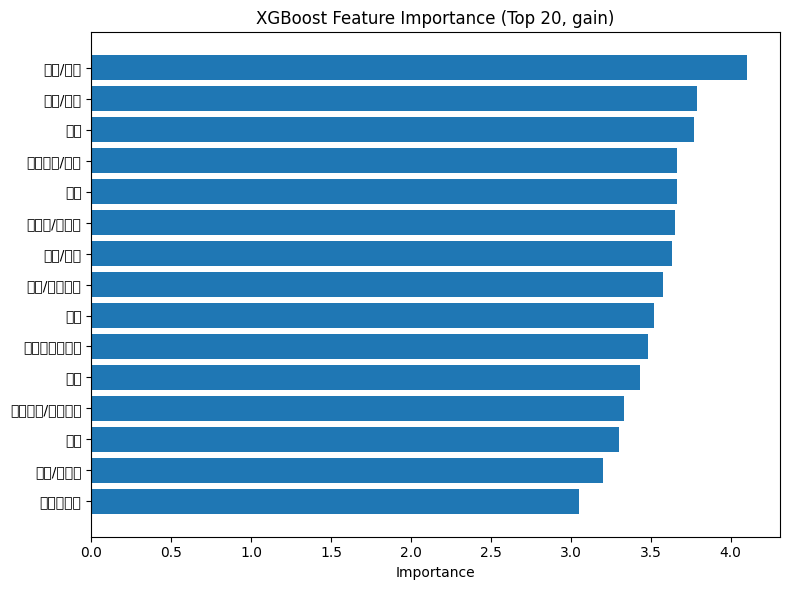

In [6]:
# # =========================================
# # 인사평가 이진분류 - 정확도 최대화 최종 코드 (xgboost 3.0.3)
# # =========================================
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score, f1_score,
#     classification_report, confusion_matrix
# )

# import xgboost as xgb

# # -------------------------
# # 0) 데이터 로드 & 타깃 설정
# # -------------------------
# CSV_PATH = r"C:\Users\Admin\OneDrive\바탕 화면\2차 플젝\WA_Fn-UseC_-HR-Employee-Attrition_피쳐변환.csv"  # <- 경로 확인/수정
# TARGET_COL = "업무평가"  # <- 실제 타깃 컬럼명으로 맞추세요

# df = pd.read_csv(CSV_PATH)

# # (문자 타깃이면 매핑)
# if df[TARGET_COL].dtype == "O":
#     df[TARGET_COL] = df[TARGET_COL].map({"보통": 0, "좋다": 1}).astype(int)

# y = df[TARGET_COL].values
# X = df.drop(columns=[TARGET_COL])

# # 숫자/범주형 컬럼 자동 구분
# cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
# num_cols = X.select_dtypes(include=[np.number, "float64", "int64", "int32", "float32"]).columns.tolist()

# print(f"📊 피처: {X.shape[1]} | 숫자형: {len(num_cols)} | 범주형: {len(cat_cols)}")

# # -------------------------
# # 1) 데이터 분할 (train/val/test)
# # -------------------------
# X_train, X_temp, y_train, y_temp = train_test_split(
#     X, y, test_size=0.30, random_state=42, stratify=y
# )
# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
# )

# # -------------------------
# # 2) 전처리 파이프라인 (표준화 + OHE)
# # -------------------------
# num_tf = Pipeline(steps=[("scaler", StandardScaler())])
# cat_tf = Pipeline(steps=[("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

# preprocess = ColumnTransformer(
#     transformers=[
#         ("num", num_tf, num_cols),
#         ("cat", cat_tf, cat_cols)
#     ],
#     remainder="drop"
# )

# # -------------------------
# # 3) 전처리 적합/변환 + 피처명 생성
# # -------------------------
# prep = preprocess.fit(X_train, y_train)
# X_train_t = prep.transform(X_train)
# X_val_t   = prep.transform(X_val)
# X_test_t  = prep.transform(X_test)

# num_feature_names = num_cols
# if len(cat_cols) > 0:
#     ohe = prep.named_transformers_["cat"].named_steps["ohe"]
#     cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
# else:
#     cat_feature_names = []
# all_feature_names = num_feature_names + cat_feature_names

# # -------------------------
# # 4) DMatrix 구성
# # -------------------------
# dtrain = xgb.DMatrix(X_train_t, label=y_train, feature_names=all_feature_names)
# dval   = xgb.DMatrix(X_val_t,   label=y_val,   feature_names=all_feature_names)
# dtest  = xgb.DMatrix(X_test_t,  label=y_test,  feature_names=all_feature_names)

# # -------------------------
# # 5) scale_pos_weight 스윕(±20%) + 임계값(accuracy 기준) 탐색
# # -------------------------
# pos = (y_train == 1).sum()
# neg = (y_train == 0).sum()
# base_spw = max(1.0, neg / max(1, pos))

# spw_list = sorted(set([round(base_spw * r, 4) for r in [0.8, 0.9, 1.0, 1.1, 1.2]]))
# print(f"⚖️ base scale_pos_weight = {base_spw:.2f} | sweep = {spw_list}")

# def find_best_thr_by_acc(proba, y_true, lo=0.2, hi=0.8, step=0.01):
#     grid = np.arange(lo, hi + 1e-9, step)
#     best_thr, best_acc = 0.5, -1.0
#     for t in grid:
#         pred = (proba >= t).astype(int)
#         acc = accuracy_score(y_true, pred)
#         if acc > best_acc:
#             best_acc = acc
#             best_thr = t
#     return best_thr, best_acc

# def train_with_spw(spw):
#     params = {
#         "objective": "binary:logistic",
#         "eval_metric": "logloss",
#         "eta": 0.05,
#         "max_depth": 6,
#         "subsample": 0.8,
#         "colsample_bytree": 0.8,
#         "lambda": 1.0,                  # L2 reg
#         "scale_pos_weight": spw,
#         "tree_method": "hist",
#         "seed": 42,
#     }
#     bst = xgb.train(
#         params=params,
#         dtrain=dtrain,
#         num_boost_round=5000,
#         evals=[(dval, "val")],
#         early_stopping_rounds=50,
#         verbose_eval=False
#     )
#     best_iter = getattr(bst, "best_iteration", None)
#     if best_iter is None:
#         best_iter = bst.best_ntree_limit - 1
#     # 검증셋 확률 → 정확도 기준 임계값
#     val_proba = bst.predict(dval, iteration_range=(0, best_iter + 1))
#     thr, val_acc = find_best_thr_by_acc(val_proba, y_val)
#     return bst, best_iter, thr, val_acc

# records = []
# models  = {}

# for spw in spw_list:
#     bst, best_iter, thr, val_acc = train_with_spw(spw)
#     records.append({"spw": spw, "val_acc": val_acc, "best_thr": thr, "best_iter": best_iter})
#     models[spw] = (bst, best_iter)

# rec_df = pd.DataFrame(records).sort_values("val_acc", ascending=False)
# print("\n[VAL 성능 (accuracy 기준 정렬)]")
# print(rec_df.to_string(index=False))

# best_row  = rec_df.iloc[0]
# best_spw  = float(best_row["spw"])
# best_thr  = float(best_row["best_thr"])
# best_iter = int(best_row["best_iter"])
# bst, _    = models[best_spw]

# print(f"\n✅ 선택: spw={best_spw:.3f} | best_thr={best_thr:.3f} | val_acc={best_row['val_acc']:.4f}")

# # -------------------------
# # 6) Test 평가 (정확도 최적 임계값 적용)
# # -------------------------
# test_proba = bst.predict(dtest, iteration_range=(0, best_iter + 1))
# test_pred  = (test_proba >= best_thr).astype(int)

# acc  = accuracy_score(y_test, test_pred)
# prec = precision_score(y_test, test_pred, average="weighted", zero_division=0)
# rec  = recall_score(y_test, test_pred, average="weighted", zero_division=0)
# f1w  = f1_score(y_test, test_pred, average="weighted", zero_division=0)

# print("\n=== Test (정확도 최적 임계값 적용) ===")
# print(f"- accuracy          : {acc:.4f}")
# print(f"- precision_weighted: {prec:.4f}")
# print(f"- recall_weighted   : {rec:.4f}")
# print(f"- f1_weighted       : {f1w:.4f}")

# print("\n[Classification Report - Test]")
# print(classification_report(y_test, test_pred, digits=4, target_names=["보통(0)", "좋다(1)"]))

# cm = confusion_matrix(y_test, test_pred)
# print("\n[Confusion Matrix - Test]")
# print(cm)

# # -------------------------
# # 7) 피처 중요도 (gain 기반, OHE 이름 포함)
# # -------------------------
# imp = bst.get_score(importance_type="gain")  # dict: {feature_name: importance}
# fi_df = (pd.DataFrame(list(imp.items()), columns=["feature", "importance"])
#          .sort_values("importance", ascending=False))

# print("\n[Top 20 Feature Importances]")
# print(fi_df.head(20).to_string(index=False))

# # (선택) 시각화
# top_k = min(20, len(fi_df))
# if top_k > 0:
#     fi_top = fi_df.head(top_k).iloc[::-1]
#     plt.figure(figsize=(8, max(4, int(top_k * 0.45))))
#     plt.barh(fi_top["feature"], fi_top["importance"])
#     plt.title("XGBoost Feature Importance (Top 20, gain)")
#     plt.xlabel("Importance")
#     plt.tight_layout()
#     plt.show()

# # -------------------------
# # 8) 단건 예측 함수 (원본 컬럼명 기준 입력)
# # -------------------------
# def predict_one(sample_dict: dict, threshold: float = None):
#     """
#     sample_dict: {원본컬럼명: 값} (범주형은 원래 라벨로)
#     threshold: None이면 선택된 best_thr 사용
#     """
#     x_one = pd.DataFrame([sample_dict])[X.columns]  # 원본 컬럼 순서 맞춤
#     x_t   = prep.transform(x_one)
#     d_one = xgb.DMatrix(x_t, feature_names=all_feature_names)
#     proba = float(bst.predict(d_one, iteration_range=(0, best_iter + 1))[0])
#     thr   = best_thr if threshold is None else threshold
#     pred  = int(proba >= thr)
#     return {"proba_1": proba, "threshold": float(thr), "pred": pred}  # 0=보통, 1=좋다

# # 사용 예시:
# # sample = {"나이": 35, "부서": "R&D", "경력": 5, ...}  # 실제 컬럼명/값으로 채우기
# # print(predict_one(sample))


# 다중분류

Accuracy: 0.8197

[Classification Report]
              precision    recall  f1-score   support

          보통       0.84      0.97      0.90       249
          좋다       0.00      0.00      0.00        45

    accuracy                           0.82       294
   macro avg       0.42      0.48      0.45       294
weighted avg       0.71      0.82      0.76       294



C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  fig.canvas.draw()
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from current font.
  fig.canvas.draw()
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 51339 (\N{HANGUL SYLLABLE JOH}) missing from current font.
  fig.canvas.draw()
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from current font.
  fig.canvas.draw()
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py

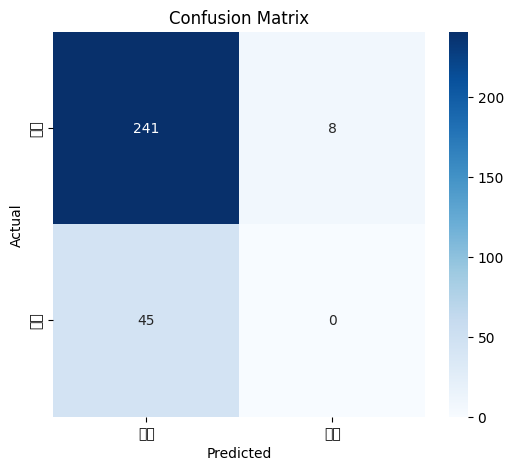

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (15,) and arg 3 with shape (20,).

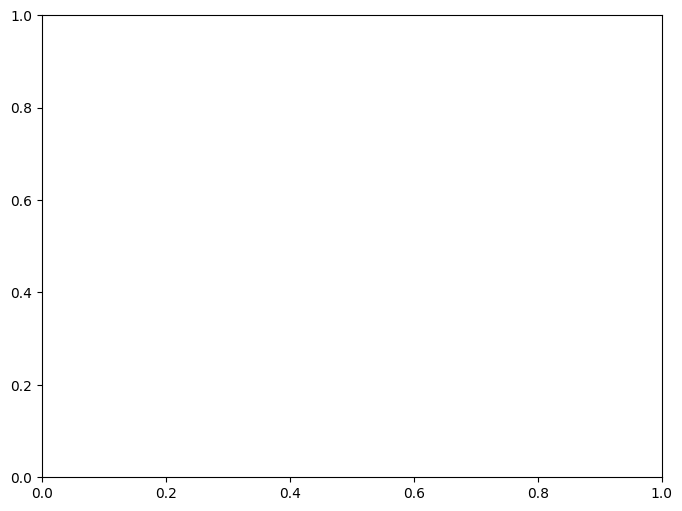

In [7]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from xgboost import XGBClassifier
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 1. 데이터 불러오기
# df = pd.read_csv(r"C:\Users\Admin\OneDrive\바탕 화면\2차 플젝\WA_Fn-UseC_-HR-Employee-Attrition_피쳐변환.csv")

# # =====================
# # 2. 타겟 & 피처 지정
# # =====================
# # 타겟: '업무평가'
# y = df['업무평가']

# # 라벨 인코딩 (다중분류용)
# le = LabelEncoder()
# y = le.fit_transform(y)   # 예: [0,1,2,3] 형태

# # 피처: 타겟 제외한 모든 열
# X = df.drop(columns=['업무평가'])

# # 범주형 변수 인코딩
# X = pd.get_dummies(X)

# # 스케일링 (선택)
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # =====================
# # 3. 데이터 분할
# # =====================
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# # =====================
# # 4. XGBoost 다중분류 모델
# # =====================
# clf = XGBClassifier(
#     objective='multi:softmax',  # 또는 'multi:softprob' (확률출력)
#     num_class=len(np.unique(y)),
#     eval_metric='mlogloss',
#     tree_method='hist',   # GPU 있으면 'gpu_hist'
#     random_state=42
# )

# # 학습
# clf.fit(X_train, y_train)

# # =====================
# # 5. 예측 및 평가
# # =====================
# y_pred = clf.predict(X_test)

# acc = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {acc:.4f}")
# print("\n[Classification Report]")
# print(classification_report(y_test, y_pred, target_names=le.classes_))

# # 혼동 행렬 시각화
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=le.classes_,
#             yticklabels=le.classes_)
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# # =====================
# # 6. 피처 중요도
# # =====================
# importances = clf.feature_importances_
# indices = np.argsort(importances)[::-1]

# plt.figure(figsize=(8,6))
# plt.barh(range(20), importances[indices][:20])
# plt.yticks(range(20), np.array(df.drop(columns=['업무평가']).columns)[indices][:20])
# plt.gca().invert_yaxis()
# plt.title("Top 20 Feature Importances")
# plt.show()
